# Click-Through Rate Prediction

In [1]:
import numpy as np
import random
n = 40428967  #total number of records in the clickstream data 
sample_size = 1000000
skip_values = sorted(random.sample(range(1,n), n-sample_size)) 

types_train = {
    'id': np.dtype(int),
    'click': np.dtype(int),
    'hour': np.dtype(int),
    'C1': np.dtype(int),
    'banner_pos': np.dtype(int),
    'site_id': np.dtype(str),
    'site_domain': np.dtype(str), 
    'site_category': np.dtype(str),
    'app_id': np.dtype(str),
    'app_domain': np.dtype(str),
    'app_category': np.dtype(str),
    'device_id': np.dtype(str),
    'device_ip': np.dtype(str),
    'device_model': np.dtype(str),
    'device_type': np.dtype(int),
    'device_conn_type': np.dtype(int),
    'C14': np.dtype(int),
    'C15': np.dtype(int),
    'C16': np.dtype(int),
    'C17': np.dtype(int),
    'C18': np.dtype(int),
    'C19': np.dtype(int),
    'C20': np.dtype(int),
    'C21':np.dtype(int)
}

types_test = {
    'id': np.dtype(int),
    'hour': np.dtype(int),
    'C1': np.dtype(int),
    'banner_pos': np.dtype(int),
    'site_id': np.dtype(str),
    'site_domain': np.dtype(str), 
    'site_category': np.dtype(str),
    'app_id': np.dtype(str),
    'app_domain': np.dtype(str),
    'app_category': np.dtype(str),
    'device_id': np.dtype(str),
    'device_ip': np.dtype(str),
    'device_model': np.dtype(str),
    'device_type': np.dtype(int),
    'device_conn_type': np.dtype(int),
    'C14': np.dtype(int),
    'C15': np.dtype(int),
    'C16': np.dtype(int),
    'C17': np.dtype(int),
    'C18': np.dtype(int),
    'C19': np.dtype(int),
    'C20': np.dtype(int),
    'C21':np.dtype(int)
}

In [2]:
import pandas as pd
import gzip

parse_date = lambda val : pd.datetime.strptime(val, '%y%m%d%H')

with gzip.open('train.gz') as f:
    train = pd.read_csv(f, parse_dates = ['hour'], date_parser = parse_date, dtype=types_train, skiprows = skip_values)

train.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,601394868,0,2014-10-21,1005,0,030440fe,08ba7db9,76b2941d,ecad2386,7801e8d9,...,1,0,18993,320,50,2161,0,35,-1,157
1,-59070594,0,2014-10-21,1005,1,0eb72673,d2f72222,f028772b,ecad2386,7801e8d9,...,1,0,16208,320,50,1800,3,167,100075,23
2,-1859646727,0,2014-10-21,1005,0,6c5b482c,7687a86e,3e814130,ecad2386,7801e8d9,...,1,0,17654,300,250,1994,2,39,100083,33
3,497487217,0,2014-10-21,1005,0,85f751fd,c4e18dd6,50e219e0,febd1138,82e27996,...,1,0,21611,320,50,2480,3,297,100111,61
4,-1852466777,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15706,320,50,1722,0,35,-1,79


In [3]:
train.shape

(1000000, 24)

In [4]:
train.dtypes

id                           int32
click                        int32
hour                datetime64[ns]
C1                           int32
banner_pos                   int32
site_id                     object
site_domain                 object
site_category               object
app_id                      object
app_domain                  object
app_category                object
device_id                   object
device_ip                   object
device_model                object
device_type                  int32
device_conn_type             int32
C14                          int32
C15                          int32
C16                          int32
C17                          int32
C18                          int32
C19                          int32
C20                          int32
C21                          int32
dtype: object

Target feature -> click

site features -> site_id, site_domain, site_category

app feature -> app_id, app_domain, app_category

device feature -> device_id, device_ip, device_model, device_type, device_conn_type

anonymized categorical features -> C14-C21

In [5]:
train['click'].value_counts()

0    830423
1    169577
Name: click, dtype: int64

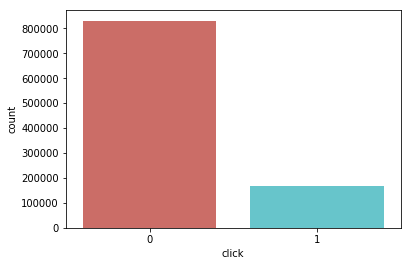

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='click',data=train, palette='hls')
plt.show();

In [8]:
train['click'].value_counts()/len(train)

0    0.830423
1    0.169577
Name: click, dtype: float64

Click through rate is approx. 17%, and approx. 83% is not clicked. 

In [9]:
train.hour.describe()

count                 1000000
unique                    240
top       2014-10-22 09:00:00
freq                    11144
first     2014-10-21 00:00:00
last      2014-10-30 23:00:00
Name: hour, dtype: object

The data covers 10 days of click streams data from 2014-10-21 to 2014-10-30, that is 240 hours.

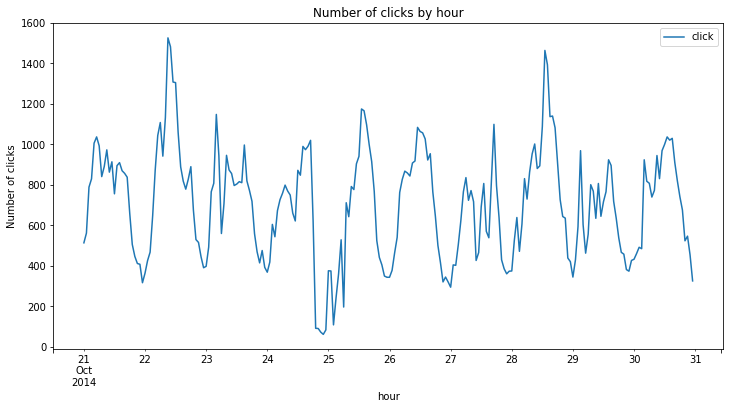

In [10]:
train.groupby('hour').agg({'click':'sum'}).plot(figsize=(12,6))
plt.ylabel('Number of clicks')
plt.title('Number of clicks by hour');

The hourly clicks pattern looks pretty similar every day. However, there were a couple of peak hours, one is sometime in the mid of the day on Oct 22, and another is sometime in the mid of the day on Oct 28. And one off-peak hour is close to mid-night on Oct 24.

###  Feature engineering for date time features

#### Hour

Extract hour from date time feature.

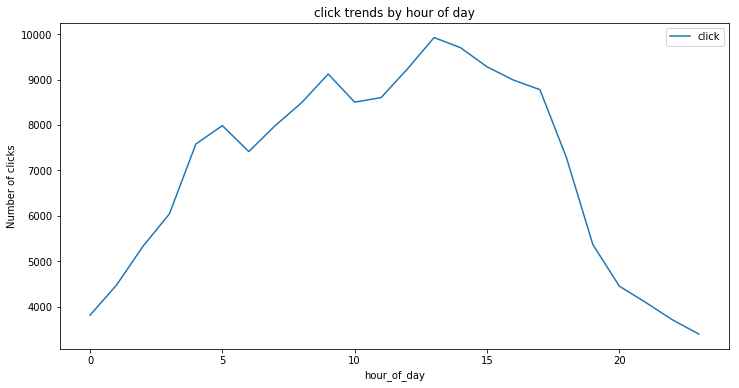

In [11]:
train['hour_of_day'] = train.hour.apply(lambda x: x.hour)
train.groupby('hour_of_day').agg({'click':'sum'}).plot(figsize=(12,6))
plt.ylabel('Number of clicks')
plt.title('click trends by hour of day');

In general, the highest number of clicks is at hour 13 and 14 (1pm and 2pm), and the least number of clicks is at hour 0 (mid-night). It seems a useful feature for roughly estimation.

In [12]:
train.head(3)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,hour_of_day
0,601394868,0,2014-10-21,1005,0,030440fe,08ba7db9,76b2941d,ecad2386,7801e8d9,...,0,18993,320,50,2161,0,35,-1,157,0
1,-59070594,0,2014-10-21,1005,1,0eb72673,d2f72222,f028772b,ecad2386,7801e8d9,...,0,16208,320,50,1800,3,167,100075,23,0
2,-1859646727,0,2014-10-21,1005,0,6c5b482c,7687a86e,3e814130,ecad2386,7801e8d9,...,0,17654,300,250,1994,2,39,100083,33,0


Let's take impressions into consideration.

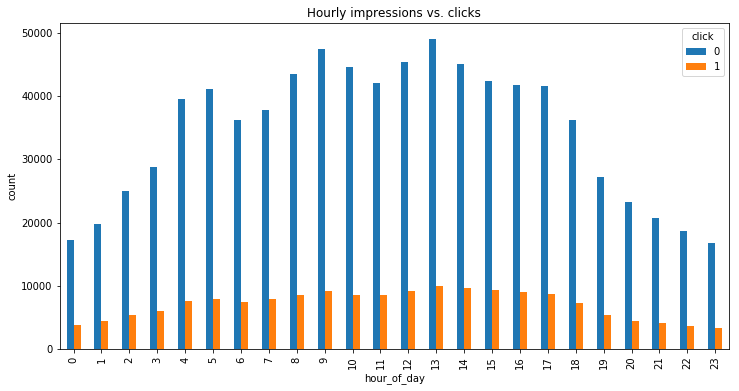

In [13]:
train.groupby(['hour_of_day', 'click']).size().unstack().plot(kind='bar', title="Hour of Day", figsize=(12,6))
plt.ylabel('count')
plt.title('Hourly impressions vs. clicks');

There is nothing shocking here.

In [14]:
train.head(3)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,hour_of_day
0,601394868,0,2014-10-21,1005,0,030440fe,08ba7db9,76b2941d,ecad2386,7801e8d9,...,0,18993,320,50,2161,0,35,-1,157,0
1,-59070594,0,2014-10-21,1005,1,0eb72673,d2f72222,f028772b,ecad2386,7801e8d9,...,0,16208,320,50,1800,3,167,100075,23,0
2,-1859646727,0,2014-10-21,1005,0,6c5b482c,7687a86e,3e814130,ecad2386,7801e8d9,...,0,17654,300,250,1994,2,39,100083,33,0


Now that we have click and impression. We can calculate Click-through rate (CTR). CTR is the ratio of ad clicks to impressions. It measures the rate of clicks on each ad.

#### Hourly CTR

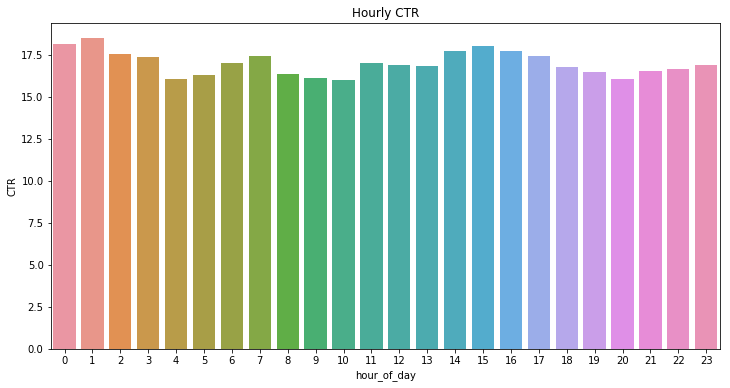

In [15]:
import seaborn as sns

df_click = train[train['click'] == 1]
df_hour = train[['hour_of_day','click']].groupby(['hour_of_day']).count().reset_index()
df_hour = df_hour.rename(columns={'click': 'impressions'})
df_hour['clicks'] = df_click[['hour_of_day','click']].groupby(['hour_of_day']).count().reset_index()['click']
df_hour['CTR'] = df_hour['clicks']/df_hour['impressions']*100

plt.figure(figsize=(12,6))
sns.barplot(y='CTR', x='hour_of_day', data=df_hour)
plt.title('Hourly CTR');

One of the interesting observations here is that the highest CTR happened in the hour of mid-night, 1, 7 and 15. If you remember, around mid-night has the least number of impressions and clicks.

#### Day of week

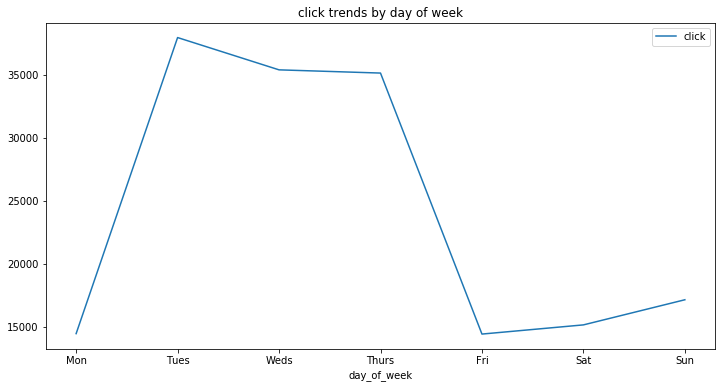

In [16]:
train['day_of_week'] = train['hour'].apply(lambda val: val.weekday_name)
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
train.groupby('day_of_week').agg({'click':'sum'}).reindex(cats).plot(figsize=(12,6))
ticks = list(range(0, 7, 1)) # points on the x axis where you want the label to appear
labels = "Mon Tues Weds Thurs Fri Sat Sun".split()
plt.xticks(ticks, labels)
plt.title('click trends by day of week');

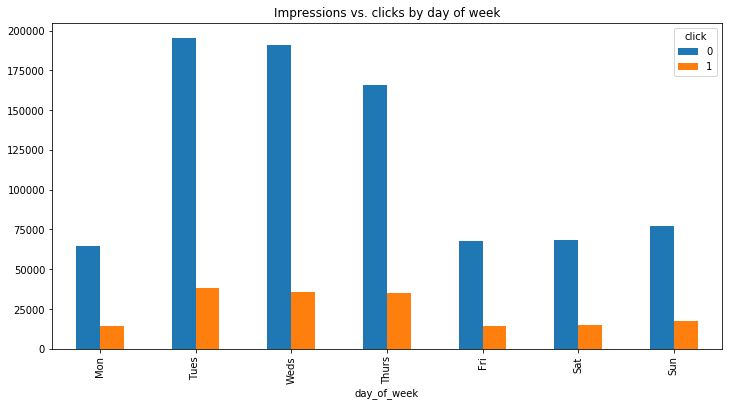

In [17]:
train.groupby(['day_of_week','click']).size().unstack().reindex(cats).plot(kind='bar', title="Day of the Week", figsize=(12,6))
ticks = list(range(0, 7, 1)) # points on the x axis where you want the label to appear
labels = "Mon Tues Weds Thurs Fri Sat Sun".split()
plt.xticks(ticks, labels)
plt.title('Impressions vs. clicks by day of week');

Tuesdays have the most impressions and clicks, then Wednesdays, followed by Thursdays. Mondays and Fridays have the least number of impressions and clicks.

#### Day of week CTR

In [18]:
train.head(3)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,C14,C15,C16,C17,C18,C19,C20,C21,hour_of_day,day_of_week
0,601394868,0,2014-10-21,1005,0,030440fe,08ba7db9,76b2941d,ecad2386,7801e8d9,...,18993,320,50,2161,0,35,-1,157,0,Tuesday
1,-59070594,0,2014-10-21,1005,1,0eb72673,d2f72222,f028772b,ecad2386,7801e8d9,...,16208,320,50,1800,3,167,100075,23,0,Tuesday
2,-1859646727,0,2014-10-21,1005,0,6c5b482c,7687a86e,3e814130,ecad2386,7801e8d9,...,17654,300,250,1994,2,39,100083,33,0,Tuesday


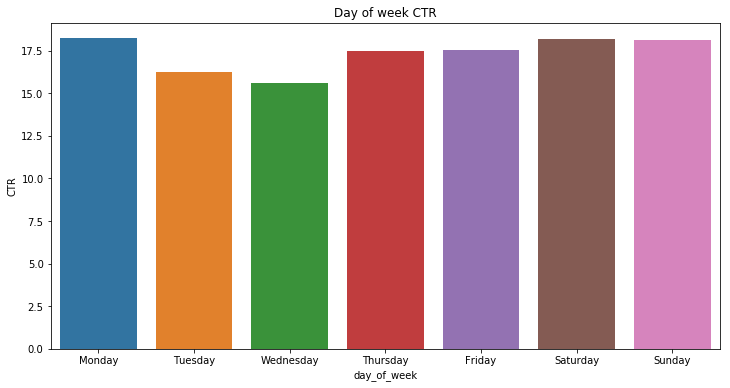

In [19]:
df_click = train[train['click'] == 1]
df_dayofweek = train[['day_of_week','click']].groupby(['day_of_week']).count().reset_index()
df_dayofweek = df_dayofweek.rename(columns={'click': 'impressions'})
df_dayofweek['clicks'] = df_click[['day_of_week','click']].groupby(['day_of_week']).count().reset_index()['click']
df_dayofweek['CTR'] = df_dayofweek['clicks']/df_dayofweek['impressions']*100

plt.figure(figsize=(12,6))
sns.barplot(y='CTR', x='day_of_week', data=df_dayofweek, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Day of week CTR');

While Tuesdays and Wednesdays have the highest number of impressions and clicks, their CTR are among the lowest. Saturdays and Sundays enjoy the highest CTR. Apparently, people have more time to click over the weekend.

In [20]:
train.head(3)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,C14,C15,C16,C17,C18,C19,C20,C21,hour_of_day,day_of_week
0,601394868,0,2014-10-21,1005,0,030440fe,08ba7db9,76b2941d,ecad2386,7801e8d9,...,18993,320,50,2161,0,35,-1,157,0,Tuesday
1,-59070594,0,2014-10-21,1005,1,0eb72673,d2f72222,f028772b,ecad2386,7801e8d9,...,16208,320,50,1800,3,167,100075,23,0,Tuesday
2,-1859646727,0,2014-10-21,1005,0,6c5b482c,7687a86e,3e814130,ecad2386,7801e8d9,...,17654,300,250,1994,2,39,100083,33,0,Tuesday


### C1 feature

C1 is one of the anonymized categorical features. Although we don't know its meaning, we still want to have a look its distribution.

In [21]:
print(train.C1.value_counts()/len(train))

1005    0.918462
1002    0.055026
1010    0.022414
1012    0.002856
1007    0.000873
1001    0.000245
1008    0.000124
Name: C1, dtype: float64


C1 value = 1005 has the most data, almost 92%. Let's see whether we can find value of C1 indicates something about CTR.

In [22]:
C1_values = train.C1.unique()
C1_values.sort()
ctr_avg_list=[]
for i in C1_values:
    ctr_avg=train.loc[np.where((train.C1 == i))].click.mean()
    ctr_avg_list.append(ctr_avg)
    print("for C1 value: {},  click through rate: {}".format(i,ctr_avg))

for C1 value: 1001,  click through rate: 0.02040816326530612
for C1 value: 1002,  click through rate: 0.2116454039908407
for C1 value: 1005,  click through rate: 0.1690423773656395
for C1 value: 1007,  click through rate: 0.048109965635738834
for C1 value: 1008,  click through rate: 0.1532258064516129
for C1 value: 1010,  click through rate: 0.094985277058981
for C1 value: 1012,  click through rate: 0.16701680672268907


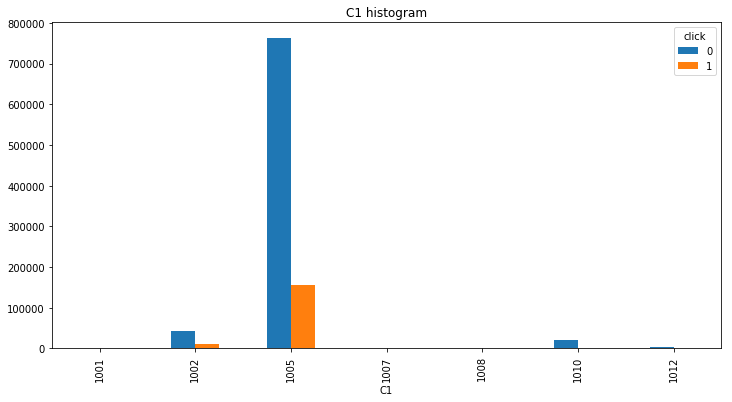

In [23]:
train.groupby(['C1', 'click']).size().unstack().plot(kind='bar', figsize=(12,6), title='C1 histogram');

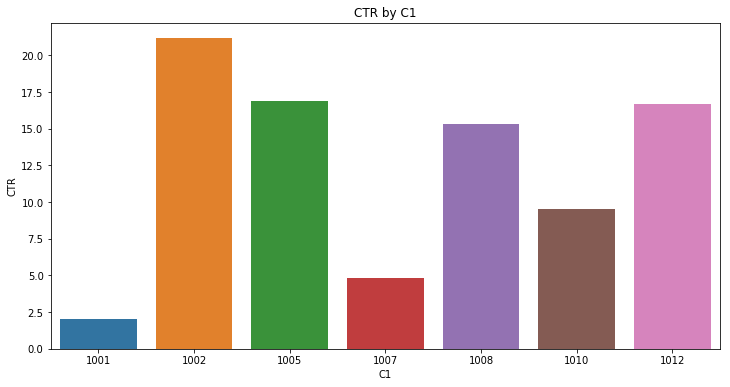

In [24]:
df_c1 = train[['C1','click']].groupby(['C1']).count().reset_index()
df_c1 = df_c1.rename(columns={'click': 'impressions'})
df_c1['clicks'] = df_click[['C1','click']].groupby(['C1']).count().reset_index()['click']
df_c1['CTR'] = df_c1['clicks']/df_c1['impressions']*100

plt.figure(figsize=(12,6))
sns.barplot(y='CTR', x='C1', data=df_c1)
plt.title('CTR by C1');

The average CTR in the data is 0.17.

In [98]:
train['click'].mean()

0.169577

In [25]:
df_c1.CTR.describe()

count     7.000000
mean     12.349054
std       7.041038
min       2.040816
25%       7.154762
50%      15.322581
75%      16.802959
max      21.164540
Name: CTR, dtype: float64

The important C1 values and CTR pairs are:

1005: 92% of the data and 0.17 CTR

1002: 5.5% of the data and 0.21 CTR

1010: 2.3% of the data and 0.096 CTR

1002 has a much higher than average CTR, and 1010 has a much lower than average CTR, it seems these two C1 values are important for predicting CTR.

### Banner position

I have heard that there are many factors that affect the performance of your banner ads, but the most influential one is the banner position. Let's see whether it is true.

In [26]:
print(train.banner_pos.value_counts()/len(train))

0    0.718949
1    0.279209
7    0.001108
2    0.000361
4    0.000200
5    0.000124
3    0.000049
Name: banner_pos, dtype: float64


In [27]:
banner_pos = train.banner_pos.unique()
banner_pos.sort()
ctr_avg_list=[]
for i in banner_pos:
    ctr_avg=train.loc[np.where((train.banner_pos == i))].click.mean()
    ctr_avg_list.append(ctr_avg)
    print("for banner position: {},  click through rate: {}".format(i,ctr_avg))

for banner position: 0,  click through rate: 0.16418828039262867
for banner position: 1,  click through rate: 0.18292748442922685
for banner position: 2,  click through rate: 0.09695290858725762
for banner position: 3,  click through rate: 0.1836734693877551
for banner position: 4,  click through rate: 0.185
for banner position: 5,  click through rate: 0.1532258064516129
for banner position: 7,  click through rate: 0.3240072202166065


The important banner positions are:

position 0: 72% of the data and 0.16 CTR

position 1: 28% of the data and 0.18 CTR

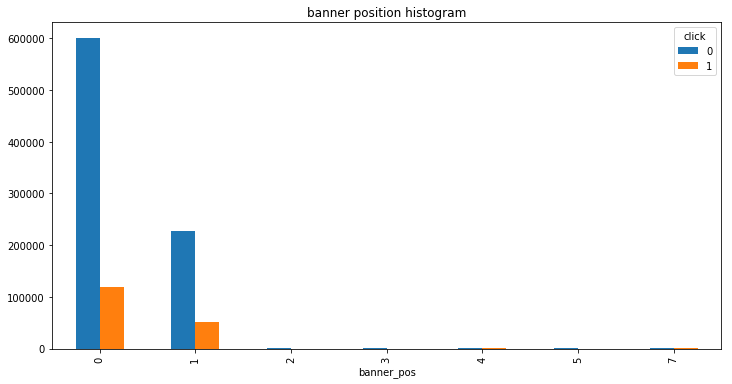

In [28]:
train.groupby(['banner_pos', 'click']).size().unstack().plot(kind='bar', figsize=(12,6), title='banner position histogram');

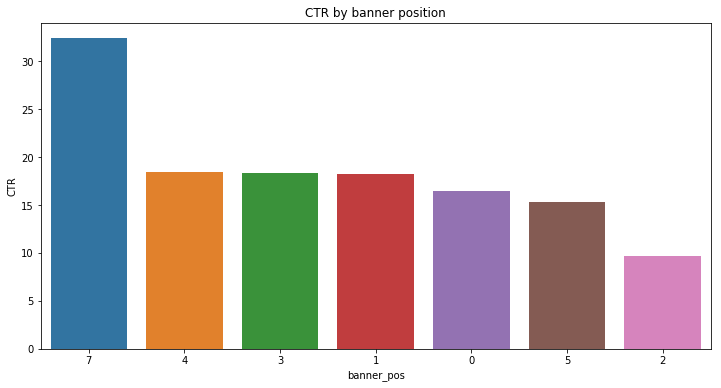

In [29]:
df_banner = train[['banner_pos','click']].groupby(['banner_pos']).count().reset_index()
df_banner = df_banner.rename(columns={'click': 'impressions'})
df_banner['clicks'] = df_click[['banner_pos','click']].groupby(['banner_pos']).count().reset_index()['click']
df_banner['CTR'] = df_banner['clicks']/df_banner['impressions']*100
sort_banners = df_banner.sort_values(by='CTR',ascending=False)['banner_pos'].tolist()
plt.figure(figsize=(12,6))
sns.barplot(y='CTR', x='banner_pos', data=df_banner, order=sort_banners)
plt.title('CTR by banner position');

In [30]:
df_banner.CTR.describe()

count     7.000000
mean     18.428217
std       6.894499
min       9.695291
25%      15.870704
50%      18.292748
75%      18.433673
max      32.400722
Name: CTR, dtype: float64

Although banner position 0 and 1 have the highest number of impressions and clicks, banner 7 enjoys the highest click through rate. Increasing the number of ads placed on banner position 7 seems to be a good idea.

### Site features

#### site id

In [31]:
print("There are {} sites in the data set".format(train.site_id.nunique()))

There are 2624 sites in the data set


In [32]:
print('The top 10 site ids that have the most impressions')
print((train.site_id.value_counts()/len(train))[0:10])

The top 10 site ids that have the most impressions
85f751fd    0.360413
1fbe01fe    0.159926
e151e245    0.064992
d9750ee7    0.024076
5b08c53b    0.022792
5b4d2eda    0.019417
856e6d3f    0.019001
a7853007    0.011380
b7e9786d    0.009176
6399eda6    0.008599
Name: site_id, dtype: float64


In [33]:
top10_ids = (train.site_id.value_counts()/len(train))[0:10].index
click_avg_list=[]

for i in top10_ids:
    click_avg=train.loc[np.where((train.site_id == i))].click.mean()
    click_avg_list.append(click_avg)
    print("for site id value: {},  click through rate: {}".format(i,click_avg))

for site id value: 85f751fd,  click through rate: 0.1196266505370228
for site id value: 1fbe01fe,  click through rate: 0.2047071770693946
for site id value: e151e245,  click through rate: 0.2956363860167405
for site id value: d9750ee7,  click through rate: 0.28310350556570857
for site id value: 5b08c53b,  click through rate: 0.4668304668304668
for site id value: 5b4d2eda,  click through rate: 0.12432404593912551
for site id value: 856e6d3f,  click through rate: 0.040629440555760225
for site id value: a7853007,  click through rate: 0.10439367311072056
for site id value: b7e9786d,  click through rate: 0.07301656495204882
for site id value: 6399eda6,  click through rate: 0.10291894406326317


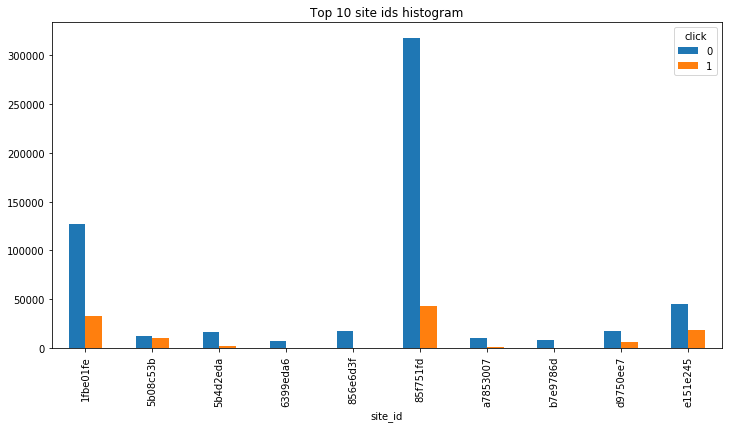

In [34]:
top10_sites = train[(train.site_id.isin((train.site_id.value_counts()/len(train))[0:10].index))]
top10_sites_click = top10_sites[top10_sites['click'] == 1]
top10_sites.groupby(['site_id', 'click']).size().unstack().plot(kind='bar', figsize=(12,6), title='Top 10 site ids histogram');

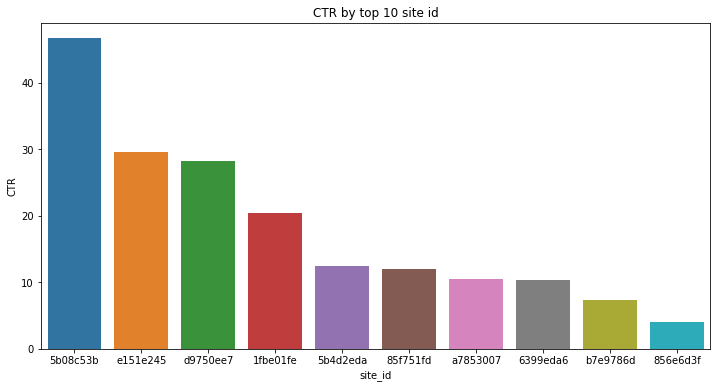

In [35]:
df_site = top10_sites[['site_id','click']].groupby(['site_id']).count().reset_index()
df_site = df_site.rename(columns={'click': 'impressions'})
df_site['clicks'] = top10_sites_click[['site_id','click']].groupby(['site_id']).count().reset_index()['click']
df_site['CTR'] = df_site['clicks']/df_site['impressions']*100
sort_site = df_site.sort_values(by='CTR',ascending=False)['site_id'].tolist()
plt.figure(figsize=(12,6))
sns.barplot(y='CTR', x='site_id', data=df_site, order=sort_site)
plt.title('CTR by top 10 site id');

The site_id feature seems important because the CTR for the top 10 sites, some as high as 0.47, and some as low as 0.04, and they are significantly different from overall CTR 0.16.

#### site domain 

In [36]:
print("There are {} site domains in the data set".format(train.site_domain.nunique()))

There are 2856 site domains in the data set


In [37]:
print('The top 10 site domains that have the most impressions')
print((train.site_domain.value_counts()/len(train))[0:10])

The top 10 site domains that have the most impressions
c4e18dd6    0.373743
f3845767    0.159926
7e091613    0.081999
7687a86e    0.032128
98572c79    0.024894
16a36ef3    0.021436
58a89a43    0.019001
b12b9f85    0.009287
9d54950b    0.009274
17d996e6    0.008683
Name: site_domain, dtype: float64


In [38]:
top10_domains = (train.site_domain.value_counts()/len(train))[0:10].index
click_avg_list=[]

for i in top10_domains:
    click_avg=train.loc[np.where((train.site_domain == i))].click.mean()
    click_avg_list.append(click_avg)
    print("for site domain value: {},  click through rate: {}".format(i,click_avg))

for site domain value: c4e18dd6,  click through rate: 0.12354746443411649
for site domain value: f3845767,  click through rate: 0.2047071770693946
for site domain value: 7e091613,  click through rate: 0.2581494896279223
for site domain value: 7687a86e,  click through rate: 0.4607507470119522
for site domain value: 98572c79,  click through rate: 0.2777777777777778
for site domain value: 16a36ef3,  click through rate: 0.13509983205821982
for site domain value: 58a89a43,  click through rate: 0.040629440555760225
for site domain value: b12b9f85,  click through rate: 0.07408205017766771
for site domain value: 9d54950b,  click through rate: 0.11063187405650204
for site domain value: 17d996e6,  click through rate: 0.32120234941840375


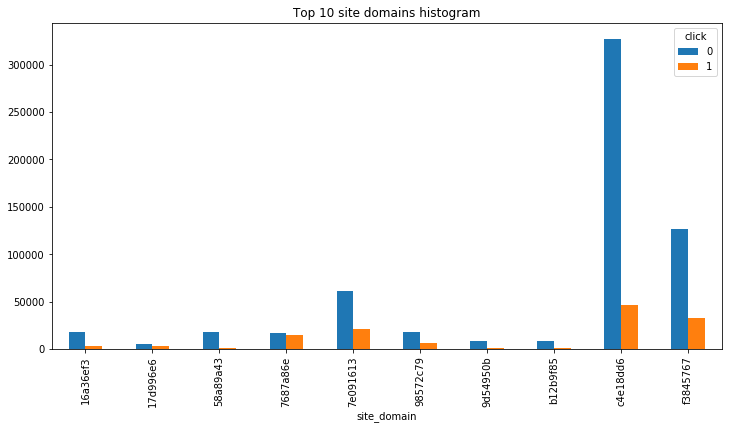

In [39]:
top10_domain = train[(train.site_domain.isin((train.site_domain.value_counts()/len(train))[0:10].index))]
top10_domain_click = top10_domain[top10_domain['click'] == 1]
top10_domain.groupby(['site_domain', 'click']).size().unstack().plot(kind='bar', figsize=(12,6), title='Top 10 site domains histogram');

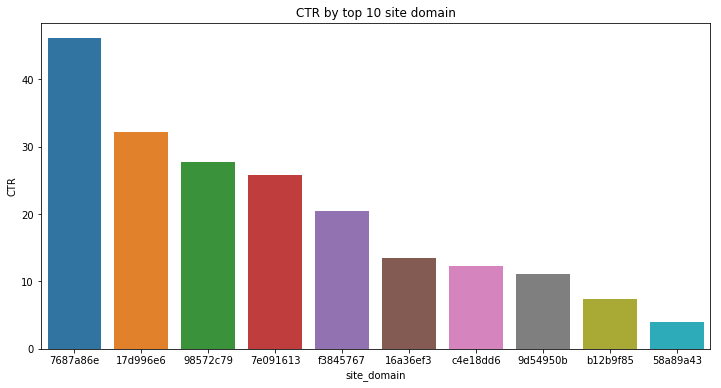

In [40]:
df_domain = top10_domain[['site_domain','click']].groupby(['site_domain']).count().reset_index()
df_domain = df_domain.rename(columns={'click': 'impressions'})
df_domain['clicks'] = top10_domain_click[['site_domain','click']].groupby(['site_domain']).count().reset_index()['click']
df_domain['CTR'] = df_domain['clicks']/df_domain['impressions']*100
sort_domain = df_domain.sort_values(by='CTR',ascending=False)['site_domain'].tolist()
plt.figure(figsize=(12,6))
sns.barplot(y='CTR', x='site_domain', data=df_domain, order=sort_domain)
plt.title('CTR by top 10 site domain');

Similar with the site_id feature, the site_domain feature seems important as well.

#### site category

In [41]:
print("There are {} site categories in the data set".format(train.site_category.nunique()))

There are 22 site categories in the data set


In [42]:
print('The top 10 site categories that have the most impressions')
print((train.site_category.value_counts()/len(train))[0:10])

The top 10 site categories that have the most impressions
50e219e0    0.408487
f028772b    0.313889
28905ebd    0.181906
3e814130    0.075684
f66779e6    0.006175
75fa27f6    0.003969
335d28a8    0.003412
76b2941d    0.002638
c0dd3be3    0.001082
72722551    0.000697
Name: site_category, dtype: float64


In [43]:
top10_categories = (train.site_category.value_counts()/len(train))[0:10].index
click_avg_list=[]

for i in top10_categories:
    click_avg=train.loc[np.where((train.site_category == i))].click.mean()
    click_avg_list.append(click_avg)
    print("for site category value: {},  click through rate: {}".format(i,click_avg))

for site category value: 50e219e0,  click through rate: 0.1293725381713494
for site category value: f028772b,  click through rate: 0.1783401138619066
for site category value: 28905ebd,  click through rate: 0.20682110540608886
for site category value: 3e814130,  click through rate: 0.2840758945087469
for site category value: f66779e6,  click through rate: 0.04
for site category value: 75fa27f6,  click through rate: 0.1111111111111111
for site category value: 335d28a8,  click through rate: 0.08997655334114889
for site category value: 76b2941d,  click through rate: 0.02312357846853677
for site category value: c0dd3be3,  click through rate: 0.10536044362292052
for site category value: 72722551,  click through rate: 0.06312769010043041


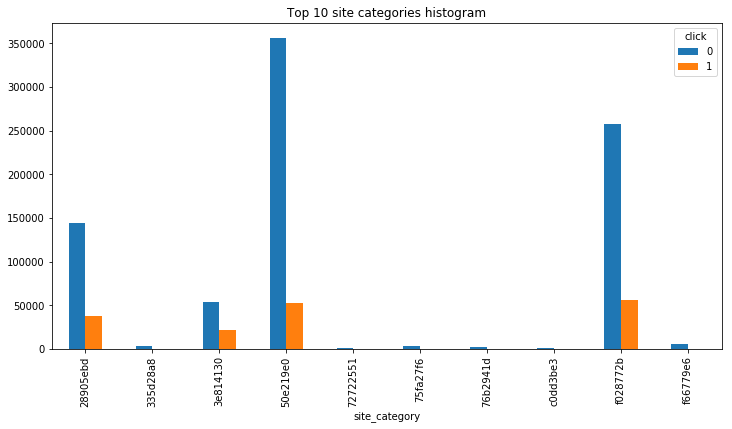

In [44]:
top10_category = train[(train.site_category.isin((train.site_category.value_counts()/len(train))[0:10].index))]
top10_category_click = top10_category[top10_category['click'] == 1]
top10_category.groupby(['site_category', 'click']).size().unstack().plot(kind='bar', figsize=(12,6), title='Top 10 site categories histogram');

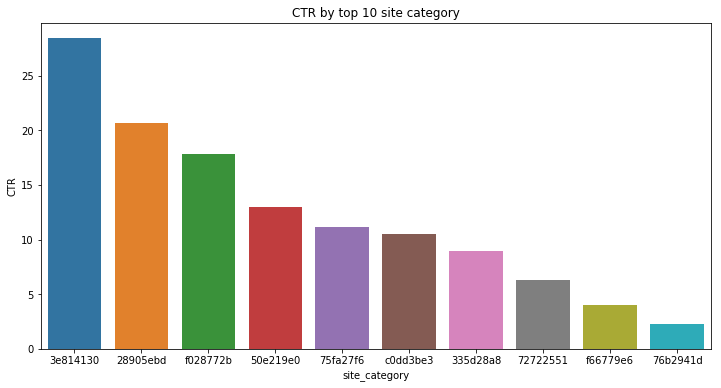

In [45]:
df_category = top10_category[['site_category','click']].groupby(['site_category']).count().reset_index()
df_category = df_category.rename(columns={'click': 'impressions'})
df_category['clicks'] = top10_category_click[['site_category','click']].groupby(['site_category']).count().reset_index()['click']
df_category['CTR'] = df_category['clicks']/df_category['impressions']*100
sort_category = df_category.sort_values(by='CTR',ascending=False)['site_category'].tolist()
plt.figure(figsize=(12,6))
sns.barplot(y='CTR', x='site_category', data=df_category, order=sort_category)
plt.title('CTR by top 10 site category');

### Device features

#### device id

In [46]:
print("There are {} devices in the data set".format(train.device_id.nunique()))

There are 150331 devices in the data set


In [47]:
print('The top 10 devices that have the most impressions')
print((train.device_id.value_counts()/len(train))[0:10])

The top 10 devices that have the most impressions
a99f214a    0.825328
0f7c61dc    0.000557
c357dbff    0.000474
936e92fb    0.000352
afeffc18    0.000212
cef4c8cc    0.000107
987552d1    0.000106
28dc8687    0.000101
d857ffbb    0.000097
b09da1c4    0.000094
Name: device_id, dtype: float64


In [48]:
top10_devices = (train.device_id.value_counts()/len(train))[0:10].index
click_avg_list=[]

for i in top10_devices:
    click_avg=train.loc[np.where((train.device_id == i))].click.mean()
    click_avg_list.append(click_avg)
    print("for device id value: {},  click through rate: {}".format(i,click_avg))

for device id value: a99f214a,  click through rate: 0.1735952251710835
for device id value: 0f7c61dc,  click through rate: 0.7432675044883303
for device id value: c357dbff,  click through rate: 0.6540084388185654
for device id value: 936e92fb,  click through rate: 0.0625
for device id value: afeffc18,  click through rate: 0.21226415094339623
for device id value: cef4c8cc,  click through rate: 0.2523364485981308
for device id value: 987552d1,  click through rate: 0.0
for device id value: 28dc8687,  click through rate: 0.0
for device id value: d857ffbb,  click through rate: 0.18556701030927836
for device id value: b09da1c4,  click through rate: 0.14893617021276595


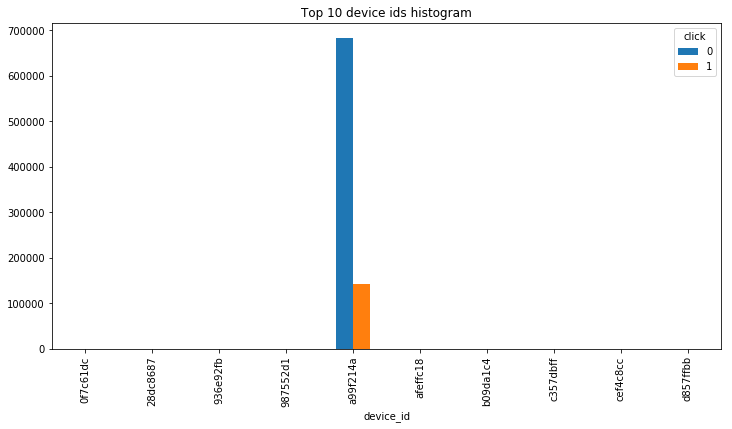

In [49]:
top10_device = train[(train.device_id.isin((train.device_id.value_counts()/len(train))[0:10].index))]
top10_device_click = top10_device[top10_device['click'] == 1]
top10_device.groupby(['device_id', 'click']).size().unstack().plot(kind='bar', figsize=(12,6), title='Top 10 device ids histogram');

You will see that most of device_id is a99f214a : Approx. 83% of the data, and the second major device_id is only 0.05% of the data. And there are some extremely high CTR here with device id at 0f7c61dc.

#### device ip

Device ip is more of a users ip address, so, there are a lot of them.

In [55]:
print("There are {} device ips in the data set".format(train.device_ip.nunique()))
print("There are {} device types in the data set".format(train.device_type.nunique()))
print("There are {} device models in the data set".format(train.device_model.nunique()))
print("There are {} device cnn types in the data set".format(train.device_conn_type.nunique()))

There are 555038 device ips in the data set
There are 5 device types in the data set
There are 5166 device models in the data set
There are 4 device cnn types in the data set


#### device type

In [58]:
print('The impressions by device types')
print((train.device_type.value_counts()/len(train)))

The impressions by device types
1    0.922559
0    0.055026
4    0.019242
5    0.003172
2    0.000001
Name: device_type, dtype: float64


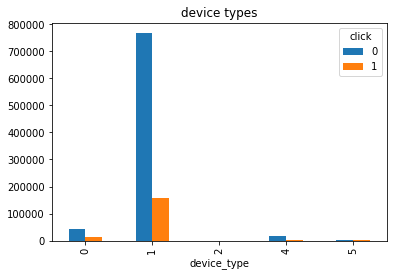

In [57]:
train[['device_type','click']].groupby(['device_type','click']).size().unstack().plot(kind='bar', title='device types');

Device type 1 gets the most impressions and clicks. And the other device types only get the minimum impressions and clicks. We may want to look in more details about device type 1. 

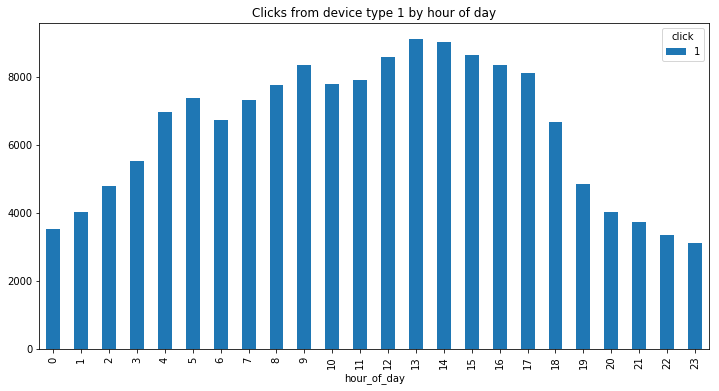

In [66]:
df_click[df_click['device_type']==1].groupby(['hour_of_day', 'click']).size().unstack().plot(kind='bar', title="Clicks from device type 1 by hour of day", figsize=(12,6));

As expected, most clicks happened during the business hours from device type 1. device type is definitely an important feature. 

In [71]:
device_type_click = df_click.groupby('device_type').agg({'click':'sum'}).reset_index()
device_type_impression = train.groupby('device_type').agg({'click':'count'}).reset_index().rename(columns={'click': 'impressions'})
merged_device_type = pd.merge(left = device_type_click , right = device_type_impression, how = 'inner', on = 'device_type')

In [75]:
merged_device_type['CTR'] = merged_device_type['click'] / merged_device_type['impressions']*100

In [76]:
merged_device_type

,device_type,click,impressions,CTR
0,0,11646,55026,21.164540
1,1,155802,922559,16.888026
2,4,1829,19242,9.505249
3,5,300,3172,9.457755


The highest CTR comes from device type 0.

#### app features

In [80]:
print("There are {} apps in the data set".format(train.app_id.nunique()))
print("There are {} app domains in the data set".format(train.app_domain.nunique()))
print("There are {} app categories in the data set".format(train.app_category.nunique()))

There are 3098 apps in the data set
There are 185 app domains in the data set
There are 25 app categories in the data set


Looks like app category something worth to explore.

In [81]:
print('The impressions by app categories')
print((train.app_category.value_counts()/len(train)))

The impressions by app categories
07d7df22    0.647835
0f2161f8    0.236489
cef3e649    0.042549
8ded1f7a    0.036035
f95efa07    0.028202
d1327cf5    0.003043
dc97ec06    0.001385
09481d60    0.001359
75d80bbe    0.000960
fc6fa53d    0.000566
4ce2e9fc    0.000502
879c24eb    0.000283
a3c42688    0.000277
4681bb9d    0.000163
0f9a328c    0.000129
a86a3e89    0.000070
2281a340    0.000053
8df2e842    0.000039
79f0b860    0.000015
0bfbc358    0.000011
2fc4f2aa    0.000010
7113d72a    0.000009
a7fd01ec    0.000008
18b1e0be    0.000004
5326cf99    0.000004
Name: app_category, dtype: float64


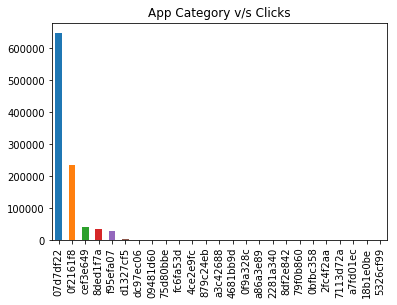

In [83]:
train['app_category'].value_counts().plot(kind='bar', title='App Category v/s Clicks')

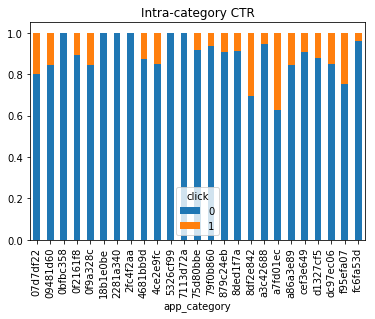

In [89]:
train_app_category = train.groupby(['app_category', 'click']).size().unstack()
train_app_category.div(train_app_category.sum(axis=1), axis=0).plot(kind='bar', stacked=True, title="Intra-category CTR");

#### C14 - C21 features

In [94]:
print("There are {} C14 in the data set".format(train.C14.nunique()))
print("There are {} C15 in the data set".format(train.C15.nunique()))
print("There are {} C16 in the data set".format(train.C16.nunique()))
print("There are {} C17 in the data set".format(train.C17.nunique()))
print("There are {} C18 in the data set".format(train.C18.nunique()))
print("There are {} C19 in the data set".format(train.C19.nunique()))
print("There are {} C20 in the data set".format(train.C20.nunique()))

There are 2253 C14 in the data set
There are 8 C15 in the data set
There are 9 C16 in the data set
There are 421 C17 in the data set
There are 4 C18 in the data set
There are 66 C19 in the data set
There are 162 C20 in the data set


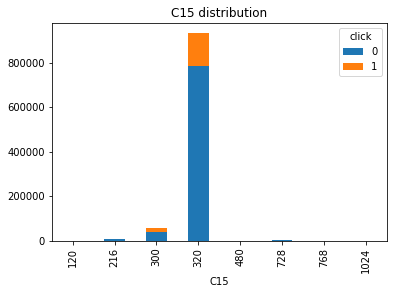

In [95]:
train.groupby(['C15', 'click']).size().unstack().plot(kind='bar', stacked=True, title='C15 distribution');

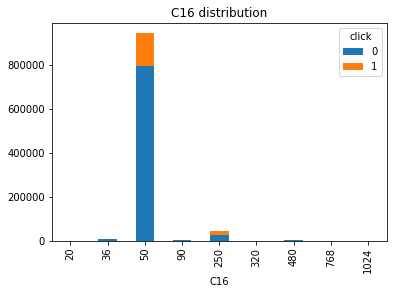

In [96]:
train.groupby(['C16', 'click']).size().unstack().plot(kind='bar', stacked=True, title='C16 distribution');

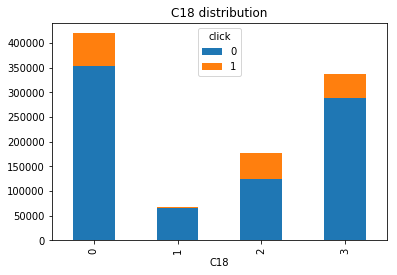

In [97]:
train.groupby(['C18', 'click']).size().unstack().plot(kind='bar', stacked=True, title='C18 distribution');

In [99]:
train.head(3)

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,C14,C15,C16,C17,C18,C19,C20,C21,hour_of_day,day_of_week
0,601394868,0,2014-10-21,1005,0,030440fe,08ba7db9,76b2941d,ecad2386,7801e8d9,...,18993,320,50,2161,0,35,-1,157,0,Tuesday
1,-59070594,0,2014-10-21,1005,1,0eb72673,d2f72222,f028772b,ecad2386,7801e8d9,...,16208,320,50,1800,3,167,100075,23,0,Tuesday
2,-1859646727,0,2014-10-21,1005,0,6c5b482c,7687a86e,3e814130,ecad2386,7801e8d9,...,17654,300,250,1994,2,39,100083,33,0,Tuesday


In [102]:
def convert_obj_to_int(self):
    
    object_list_columns = self.columns
    object_list_dtypes = self.dtypes
    new_col_suffix = '_int'
    for index in range(0,len(object_list_columns)):
        if object_list_dtypes[index] == object :
            self[object_list_columns[index]+new_col_suffix] = self[object_list_columns[index]].map( lambda  x: hash(x))
            self.drop([object_list_columns[index]],inplace=True,axis=1)
    return self
train = convert_obj_to_int(train)

In [103]:
train.head(3)

,id,click,hour,C1,banner_pos,device_type,device_conn_type,C14,C15,C16,...,site_id_int,site_domain_int,site_category_int,app_id_int,app_domain_int,app_category_int,device_id_int,device_ip_int,device_model_int,day_of_week_int
0,601394868,0,2014-10-21,1005,0,1,0,18993,320,50,...,8500684130855743782,3737552770353539727,-579286838256366625,-2575423656169186573,3543033699936297072,7752593096380383011,-5108016823012116901,3054947797612345216,5499258876395806341,-2674915302075856112
1,-59070594,0,2014-10-21,1005,1,1,0,16208,320,50,...,5459759015144306988,-1698103573712271499,-6747152105945483740,-2575423656169186573,3543033699936297072,7752593096380383011,-5108016823012116901,-1290735900571077289,-3454875886905983617,-2674915302075856112
2,-1859646727,0,2014-10-21,1005,0,1,0,17654,300,250,...,3693588028815318457,3857419392707850031,-5544871227891909166,-2575423656169186573,3543033699936297072,7752593096380383011,-5108016823012116901,-8568811352907009621,-9097821374860032227,-2674915302075856112


In [105]:
train.drop('hour', axis=1, inplace=True)

In [109]:
train.drop('id', axis=1, inplace=True)

In [112]:
import lightgbm as lgb
X_train = train.loc[:, train.columns != 'click']
y_target = train.click.values
#create lightgbm dataset
msk = np.random.rand(len(X_train)) < 0.8
lgb_train = lgb.Dataset(X_train[msk], y_target[msk])
lgb_eval = lgb.Dataset(X_train[~msk], y_target[~msk], reference=lgb_train)

In [121]:
# specify your configurations as a dict
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': { 'binary_logloss'},
    'num_leaves': 31, # defauly leaves(31) amount for each tree
    'learning_rate': 0.08,
    'feature_fraction': 0.7, # will select 70% features before training each tree
    'bagging_fraction': 0.3, #feature_fraction, but this will random select part of data
    'bagging_freq': 5, #  perform bagging at every 5 iteration
    'verbose': 0
}

print('Start training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=4000,
                valid_sets=lgb_eval,
                early_stopping_rounds=500)

Start training...
[1]	valid_0's binary_logloss: 0.450675
Training until validation scores don't improve for 500 rounds.
[2]	valid_0's binary_logloss: 0.446337
[3]	valid_0's binary_logloss: 0.442399
[4]	valid_0's binary_logloss: 0.439119
[5]	valid_0's binary_logloss: 0.436433
[6]	valid_0's binary_logloss: 0.433844
[7]	valid_0's binary_logloss: 0.431648
[8]	valid_0's binary_logloss: 0.429778
[9]	valid_0's binary_logloss: 0.428096
[10]	valid_0's binary_logloss: 0.426571
[11]	valid_0's binary_logloss: 0.425303
[12]	valid_0's binary_logloss: 0.424066
[13]	valid_0's binary_logloss: 0.422933
[14]	valid_0's binary_logloss: 0.421888
[15]	valid_0's binary_logloss: 0.421023
[16]	valid_0's binary_logloss: 0.420212
[17]	valid_0's binary_logloss: 0.419503
[18]	valid_0's binary_logloss: 0.418866
[19]	valid_0's binary_logloss: 0.418242
[20]	valid_0's binary_logloss: 0.417684
[21]	valid_0's binary_logloss: 0.417146
[22]	valid_0's binary_logloss: 0.416616
[23]	valid_0's binary_logloss: 0.416136
[24]	val

[206]	valid_0's binary_logloss: 0.403217
[207]	valid_0's binary_logloss: 0.403176
[208]	valid_0's binary_logloss: 0.403173
[209]	valid_0's binary_logloss: 0.403157
[210]	valid_0's binary_logloss: 0.403157
[211]	valid_0's binary_logloss: 0.403123
[212]	valid_0's binary_logloss: 0.403121
[213]	valid_0's binary_logloss: 0.403104
[214]	valid_0's binary_logloss: 0.403082
[215]	valid_0's binary_logloss: 0.403076
[216]	valid_0's binary_logloss: 0.403084
[217]	valid_0's binary_logloss: 0.403083
[218]	valid_0's binary_logloss: 0.403067
[219]	valid_0's binary_logloss: 0.403046
[220]	valid_0's binary_logloss: 0.403049
[221]	valid_0's binary_logloss: 0.403041
[222]	valid_0's binary_logloss: 0.403014
[223]	valid_0's binary_logloss: 0.403002
[224]	valid_0's binary_logloss: 0.402986
[225]	valid_0's binary_logloss: 0.402995
[226]	valid_0's binary_logloss: 0.402968
[227]	valid_0's binary_logloss: 0.402962
[228]	valid_0's binary_logloss: 0.402955
[229]	valid_0's binary_logloss: 0.402924
[230]	valid_0's 

[407]	valid_0's binary_logloss: 0.401431
[408]	valid_0's binary_logloss: 0.401436
[409]	valid_0's binary_logloss: 0.401432
[410]	valid_0's binary_logloss: 0.401427
[411]	valid_0's binary_logloss: 0.401407
[412]	valid_0's binary_logloss: 0.401406
[413]	valid_0's binary_logloss: 0.401393
[414]	valid_0's binary_logloss: 0.401392
[415]	valid_0's binary_logloss: 0.401398
[416]	valid_0's binary_logloss: 0.401387
[417]	valid_0's binary_logloss: 0.401372
[418]	valid_0's binary_logloss: 0.401364
[419]	valid_0's binary_logloss: 0.40133
[420]	valid_0's binary_logloss: 0.401328
[421]	valid_0's binary_logloss: 0.401323
[422]	valid_0's binary_logloss: 0.401312
[423]	valid_0's binary_logloss: 0.40131
[424]	valid_0's binary_logloss: 0.401305
[425]	valid_0's binary_logloss: 0.401297
[426]	valid_0's binary_logloss: 0.401294
[427]	valid_0's binary_logloss: 0.401293
[428]	valid_0's binary_logloss: 0.401283
[429]	valid_0's binary_logloss: 0.401274
[430]	valid_0's binary_logloss: 0.401273
[431]	valid_0's bi

[612]	valid_0's binary_logloss: 0.40061
[613]	valid_0's binary_logloss: 0.400614
[614]	valid_0's binary_logloss: 0.400603
[615]	valid_0's binary_logloss: 0.4006
[616]	valid_0's binary_logloss: 0.400601
[617]	valid_0's binary_logloss: 0.400603
[618]	valid_0's binary_logloss: 0.400607
[619]	valid_0's binary_logloss: 0.40061
[620]	valid_0's binary_logloss: 0.400615
[621]	valid_0's binary_logloss: 0.4006
[622]	valid_0's binary_logloss: 0.400597
[623]	valid_0's binary_logloss: 0.400601
[624]	valid_0's binary_logloss: 0.400591
[625]	valid_0's binary_logloss: 0.400595
[626]	valid_0's binary_logloss: 0.400594
[627]	valid_0's binary_logloss: 0.40059
[628]	valid_0's binary_logloss: 0.400588
[629]	valid_0's binary_logloss: 0.400581
[630]	valid_0's binary_logloss: 0.400583
[631]	valid_0's binary_logloss: 0.400592
[632]	valid_0's binary_logloss: 0.400599
[633]	valid_0's binary_logloss: 0.400591
[634]	valid_0's binary_logloss: 0.40059
[635]	valid_0's binary_logloss: 0.400579
[636]	valid_0's binary_l

[815]	valid_0's binary_logloss: 0.400267
[816]	valid_0's binary_logloss: 0.400269
[817]	valid_0's binary_logloss: 0.400278
[818]	valid_0's binary_logloss: 0.400282
[819]	valid_0's binary_logloss: 0.400282
[820]	valid_0's binary_logloss: 0.400277
[821]	valid_0's binary_logloss: 0.400269
[822]	valid_0's binary_logloss: 0.400278
[823]	valid_0's binary_logloss: 0.400271
[824]	valid_0's binary_logloss: 0.40027
[825]	valid_0's binary_logloss: 0.400282
[826]	valid_0's binary_logloss: 0.400276
[827]	valid_0's binary_logloss: 0.400276
[828]	valid_0's binary_logloss: 0.400267
[829]	valid_0's binary_logloss: 0.400268
[830]	valid_0's binary_logloss: 0.400261
[831]	valid_0's binary_logloss: 0.400257
[832]	valid_0's binary_logloss: 0.400261
[833]	valid_0's binary_logloss: 0.400247
[834]	valid_0's binary_logloss: 0.400253
[835]	valid_0's binary_logloss: 0.400249
[836]	valid_0's binary_logloss: 0.400235
[837]	valid_0's binary_logloss: 0.400239
[838]	valid_0's binary_logloss: 0.400233
[839]	valid_0's b

[1016]	valid_0's binary_logloss: 0.400219
[1017]	valid_0's binary_logloss: 0.400227
[1018]	valid_0's binary_logloss: 0.400239
[1019]	valid_0's binary_logloss: 0.400248
[1020]	valid_0's binary_logloss: 0.400258
[1021]	valid_0's binary_logloss: 0.400274
[1022]	valid_0's binary_logloss: 0.400282
[1023]	valid_0's binary_logloss: 0.400281
[1024]	valid_0's binary_logloss: 0.400282
[1025]	valid_0's binary_logloss: 0.400286
[1026]	valid_0's binary_logloss: 0.400281
[1027]	valid_0's binary_logloss: 0.400289
[1028]	valid_0's binary_logloss: 0.400287
[1029]	valid_0's binary_logloss: 0.400283
[1030]	valid_0's binary_logloss: 0.400282
[1031]	valid_0's binary_logloss: 0.400274
[1032]	valid_0's binary_logloss: 0.400274
[1033]	valid_0's binary_logloss: 0.400272
[1034]	valid_0's binary_logloss: 0.400279
[1035]	valid_0's binary_logloss: 0.400273
[1036]	valid_0's binary_logloss: 0.400275
[1037]	valid_0's binary_logloss: 0.400284
[1038]	valid_0's binary_logloss: 0.40029
[1039]	valid_0's binary_logloss: 0.

[1214]	valid_0's binary_logloss: 0.400382
[1215]	valid_0's binary_logloss: 0.400392
[1216]	valid_0's binary_logloss: 0.400387
[1217]	valid_0's binary_logloss: 0.400392
[1218]	valid_0's binary_logloss: 0.400387
[1219]	valid_0's binary_logloss: 0.400383
[1220]	valid_0's binary_logloss: 0.400379
[1221]	valid_0's binary_logloss: 0.400373
[1222]	valid_0's binary_logloss: 0.40037
[1223]	valid_0's binary_logloss: 0.400372
[1224]	valid_0's binary_logloss: 0.400356
[1225]	valid_0's binary_logloss: 0.400364
[1226]	valid_0's binary_logloss: 0.400359
[1227]	valid_0's binary_logloss: 0.400352
[1228]	valid_0's binary_logloss: 0.400365
[1229]	valid_0's binary_logloss: 0.400369
[1230]	valid_0's binary_logloss: 0.400364
[1231]	valid_0's binary_logloss: 0.400359
[1232]	valid_0's binary_logloss: 0.400358
[1233]	valid_0's binary_logloss: 0.400359
[1234]	valid_0's binary_logloss: 0.400364
[1235]	valid_0's binary_logloss: 0.400361
[1236]	valid_0's binary_logloss: 0.400356
[1237]	valid_0's binary_logloss: 0.

[1413]	valid_0's binary_logloss: 0.400355
[1414]	valid_0's binary_logloss: 0.400348
[1415]	valid_0's binary_logloss: 0.400343
[1416]	valid_0's binary_logloss: 0.400344
[1417]	valid_0's binary_logloss: 0.400351
[1418]	valid_0's binary_logloss: 0.400351
[1419]	valid_0's binary_logloss: 0.40035
[1420]	valid_0's binary_logloss: 0.400356
[1421]	valid_0's binary_logloss: 0.400355
[1422]	valid_0's binary_logloss: 0.400355
[1423]	valid_0's binary_logloss: 0.400363
[1424]	valid_0's binary_logloss: 0.400366
[1425]	valid_0's binary_logloss: 0.400372
[1426]	valid_0's binary_logloss: 0.400375
[1427]	valid_0's binary_logloss: 0.400378
[1428]	valid_0's binary_logloss: 0.400389
[1429]	valid_0's binary_logloss: 0.400395
[1430]	valid_0's binary_logloss: 0.400411
[1431]	valid_0's binary_logloss: 0.400407
[1432]	valid_0's binary_logloss: 0.400406
[1433]	valid_0's binary_logloss: 0.400402
[1434]	valid_0's binary_logloss: 0.400397
[1435]	valid_0's binary_logloss: 0.400394
[1436]	valid_0's binary_logloss: 0.

In [119]:
print(gbm.best_score)
print(gbm.best_iteration)

defaultdict(<class 'dict'>, {'valid_0': {'binary_logloss': 0.40019555134958557}})
958


In [148]:
from operator import itemgetter
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import roc_auc_score

def run_default_test(train, test, features, target, random_state=0):
    eta = 0.1
    max_depth = 5
    subsample = 0.8
    colsample_bytree = 0.8
    print('XGBoost params. ETA: {}, MAX_DEPTH: {}, SUBSAMPLE: {}, COLSAMPLE_BY_TREE: {}'.format(eta, max_depth, subsample, colsample_bytree))
    params = {
        "objective": "binary:logistic",
        "booster" : "gbtree",
        "eval_metric": "logloss",
        "eta": eta,
        "max_depth": max_depth,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "silent": 1,
        "seed": random_state
    }
    num_boost_round = 260
    early_stopping_rounds = 20
    test_size = 0.2

    X_train, X_valid = train_test_split(train, test_size=test_size, random_state=random_state)
    y_train = X_train[target]
    y_valid = X_valid[target]
    dtrain = xgb.DMatrix(X_train[features], y_train)
    dvalid = xgb.DMatrix(X_valid[features], y_valid)
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=True)

In [149]:
features = ['C1', 'banner_pos', 'device_type', 'device_conn_type', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'hour_of_day',
       'site_id_int', 'site_domain_int', 'site_category_int', 'app_id_int',
       'app_domain_int', 'app_category_int', 'device_id_int', 'device_ip_int',
       'device_model_int', 'day_of_week_int']
run_default_test(train, y_target, features, 'click')

XGBoost params. ETA: 0.1, MAX_DEPTH: 5, SUBSAMPLE: 0.8, COLSAMPLE_BY_TREE: 0.8
[0]	train-logloss:0.648232	eval-logloss:0.648223
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 20 rounds.
[1]	train-logloss:0.61155	eval-logloss:0.611518
[2]	train-logloss:0.58168	eval-logloss:0.581626
[3]	train-logloss:0.556558	eval-logloss:0.55647
[4]	train-logloss:0.535377	eval-logloss:0.535272
[5]	train-logloss:0.517634	eval-logloss:0.517516
[6]	train-logloss:0.502628	eval-logloss:0.502504
[7]	train-logloss:0.490077	eval-logloss:0.489942
[8]	train-logloss:0.479384	eval-logloss:0.47925
[9]	train-logloss:0.470294	eval-logloss:0.470162
[10]	train-logloss:0.462493	eval-logloss:0.462368
[11]	train-logloss:0.455896	eval-logloss:0.455775
[12]	train-logloss:0.450228	eval-logloss:0.450099
[13]	train-logloss:0.445374	eval-logloss:0.445241
[14]	train-logloss:0.441245	eval-logloss:0.44111
[15]	train-logloss:0.437608	eval-logl

[159]	train-logloss:0.403416	eval-logloss:0.4051
[160]	train-logloss:0.403284	eval-logloss:0.404985
[161]	train-logloss:0.403271	eval-logloss:0.404979
[162]	train-logloss:0.403216	eval-logloss:0.404933
[163]	train-logloss:0.403177	eval-logloss:0.4049
[164]	train-logloss:0.403079	eval-logloss:0.404811
[165]	train-logloss:0.403067	eval-logloss:0.404802
[166]	train-logloss:0.403031	eval-logloss:0.404785
[167]	train-logloss:0.403008	eval-logloss:0.404778
[168]	train-logloss:0.402993	eval-logloss:0.404776
[169]	train-logloss:0.40298	eval-logloss:0.40477
[170]	train-logloss:0.402937	eval-logloss:0.404732
[171]	train-logloss:0.402912	eval-logloss:0.404713
[172]	train-logloss:0.40288	eval-logloss:0.404697
[173]	train-logloss:0.402828	eval-logloss:0.404654
[174]	train-logloss:0.402806	eval-logloss:0.404637
[175]	train-logloss:0.402771	eval-logloss:0.404621
[176]	train-logloss:0.402726	eval-logloss:0.404585
[177]	train-logloss:0.402682	eval-logloss:0.404558
[178]	train-logloss:0.402669	eval-logl